In [179]:
from utils.base_data_handler import BaseDataHandler
from sklearn.datasets import load_breast_cancer
import matplotlib.pyplot as plt
import seaborn as sns

In [180]:
data = load_breast_cancer(as_frame=True)
df = data.frame

handler = BaseDataHandler(df=df)
handler.try_clean_column_names()
handler.df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 31 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   mean_radius              569 non-null    float64
 1   mean_texture             569 non-null    float64
 2   mean_perimeter           569 non-null    float64
 3   mean_area                569 non-null    float64
 4   mean_smoothness          569 non-null    float64
 5   mean_compactness         569 non-null    float64
 6   mean_concavity           569 non-null    float64
 7   mean_concave_points      569 non-null    float64
 8   mean_symmetry            569 non-null    float64
 9   mean_fractal_dimension   569 non-null    float64
 10  radius_error             569 non-null    float64
 11  texture_error            569 non-null    float64
 12  perimeter_error          569 non-null    float64
 13  area_error               569 non-null    float64
 14  smoothness_error         5

In [181]:
handler.df.nunique()


mean_radius                456
mean_texture               479
mean_perimeter             522
mean_area                  539
mean_smoothness            474
mean_compactness           537
mean_concavity             537
mean_concave_points        542
mean_symmetry              432
mean_fractal_dimension     499
radius_error               540
texture_error              519
perimeter_error            533
area_error                 528
smoothness_error           547
compactness_error          541
concavity_error            533
concave_points_error       507
symmetry_error             498
fractal_dimension_error    545
worst_radius               457
worst_texture              511
worst_perimeter            514
worst_area                 544
worst_smoothness           411
worst_compactness          529
worst_concavity            539
worst_concave_points       492
worst_symmetry             500
worst_fractal_dimension    535
target                       2
dtype: int64

In [182]:
handler.df.describe()

,mean_radius,mean_texture,mean_perimeter,mean_area,mean_smoothness,mean_compactness,mean_concavity,mean_concave_points,mean_symmetry,mean_fractal_dimension,radius_error,texture_error,perimeter_error,area_error,smoothness_error,compactness_error,concavity_error,concave_points_error,symmetry_error,fractal_dimension_error,worst_radius,worst_texture,worst_perimeter,worst_area,worst_smoothness,worst_compactness,worst_concavity,worst_concave_points,worst_symmetry,worst_fractal_dimension,target
count,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000,569.000000
mean,14.127292,19.289649,91.969033,654.889104,0.096360,0.104341,0.088799,0.048919,0.181162,0.062798,0.405172,1.216853,2.866059,40.337079,0.007041,0.025478,0.031894,0.011796,0.020542,0.003795,16.269190,25.677223,107.261213,880.583128,0.132369,0.254265,0.272188,0.114606,0.290076,0.083946,0.627417
std,3.524049,4.301036,24.298981,351.914129,0.014064,0.052813,0.079720,0.038803,0.027414,0.007060,0.277313,0.551648,2.021855,45.491006,0.003003,0.017908,0.030186,0.006170,0.008266,0.002646,4.833242,6.146258,33.602542,569.356993,0.022832,0.157336,0.208624,0.065732,0.061867,0.018061,0.483918
min,6.981000,9.710000,43.790000,143.500000,0.052630,0.019380,0.000000,0.000000,0.106000,0.049960,0.111500,0.360200,0.757000,6.802000,0.001713,0.002252,0.000000,0.000000,0.007882,0.000895,7.930000,12.020000,50.410000,185.200000,0.071170,0.027290,0.000000,0.000000,0.156500,0.055040,0.000000
25%,11.700000,16.170000,75.170000,420.300000,0.086370,0.064920,0.029560,0.020310,0.161900,0.057700,0.232400,0.833900,1.606000,17.850000,0.005169,0.013080,0.015090,0.007638,0.015160,0.002248,13.010000,21.080000,84.110000,515.300000,0.116600,0.147200,0.114500,0.064930,0.250400,0.071460,0.000000
50%,13.370000,18.840000,86.240000,551.100000,0.095870,0.092630,0.061540,0.033500,0.179200,0.061540,0.324200,1.108000,2.287000,24.530000,0.006380,0.020450,0.025890,0.010930,0.018730,0.003187,14.970000,25.410000,97.660000,686.500000,0.131300,0.211900,0.226700,0.099930,0.282200,0.080040,1.000000
75%,15.780000,21.800000,104.100000,782.700000,0.105300,0.130400,0.130700,0.074000,0.195700,0.066120,0.478900,1.474000,3.357000,45.190000,0.008146,0.032450,0.042050,0.014710,0.023480,0.004558,18.790000,29.720000,125.400000,1084.000000,0.146000,0.339100,0.382900,0.161400,0.317900,0.092080,1.000000
max,28.110000,39.280000,188.500000,2501.000000,0.163400,0.345400,0.426800,0.201200,0.304000,0.097440,2.873000,4.885000,21.980000,542.200000,0.031130,0.135400,0.396000,0.052790,0.078950,0.029840,36.040000,49.540000,251.200000,4254.000000,0.222600,1.058000,1.252000,0.291000,0.663800,0.207500,1.000000


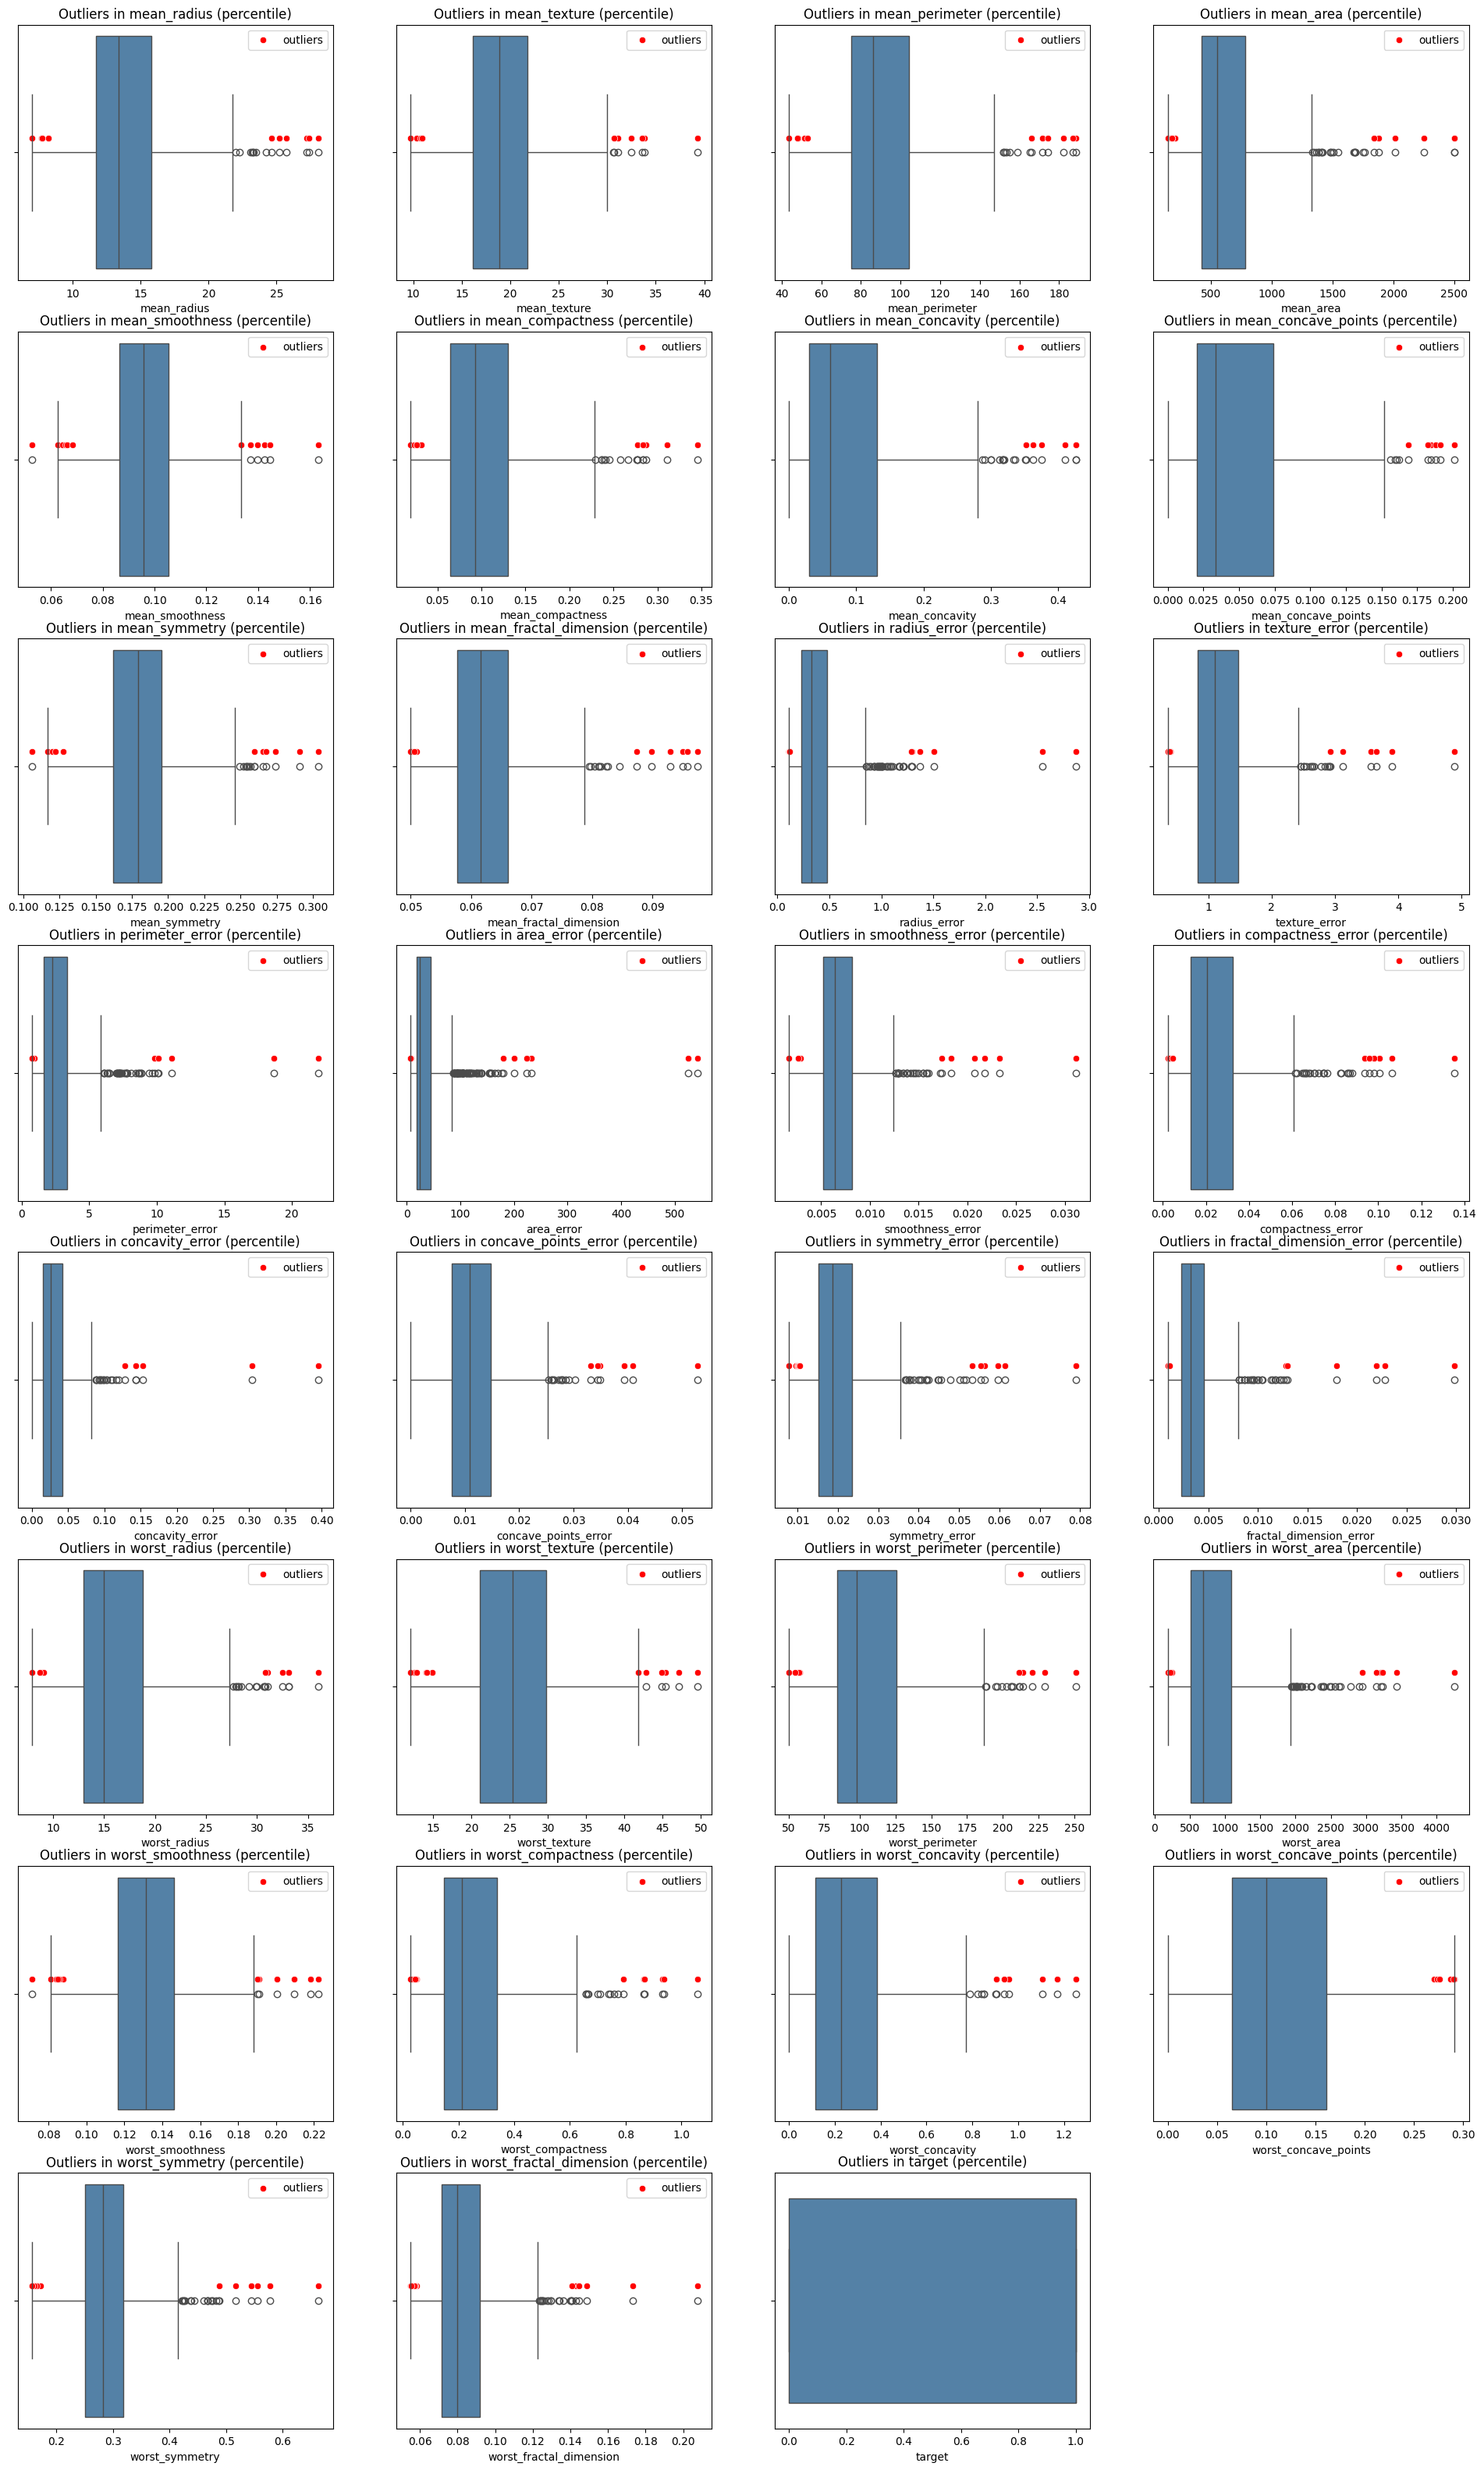

In [183]:
fig, axes = handler.get_outlier_case_study(cols=4)

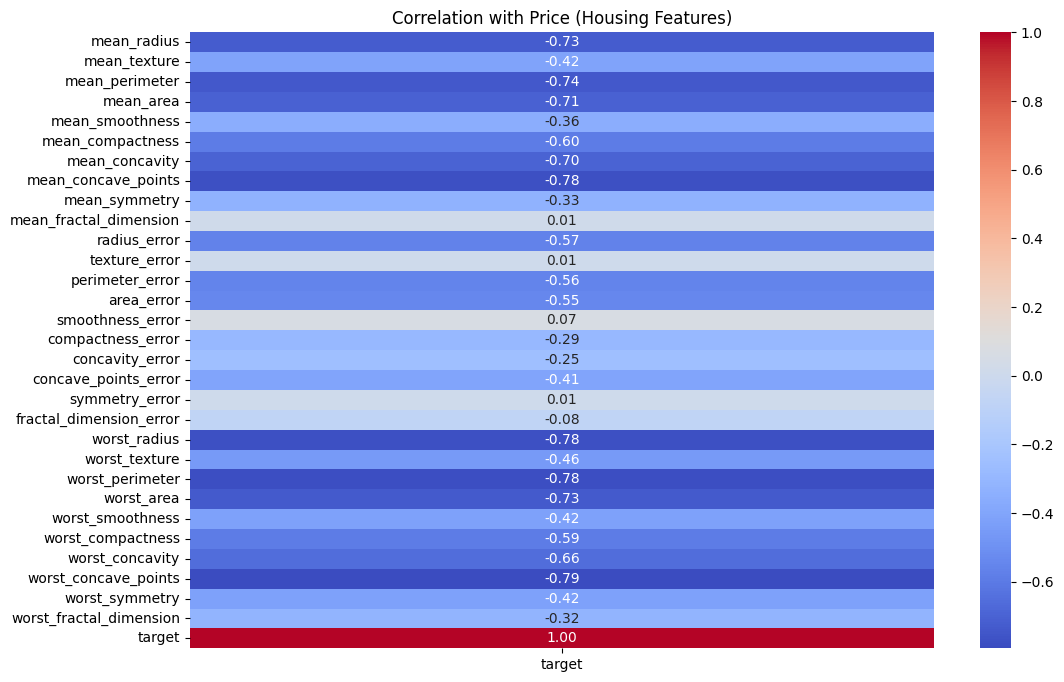

In [184]:
# Recompute correlations after dropping
corrs = handler.df.corr(numeric_only=True)["target"]

# Plot heatmap of correlations with price
plt.figure(figsize=(12, 8))
sns.heatmap(corrs.to_frame(), annot=True, fmt=".2f", cmap="coolwarm", cbar=True)
plt.title("Correlation with Price (Housing Features)")
plt.show()

In [185]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedKFold, cross_val_score, KFold
from sklearn.metrics import make_scorer, f1_score

target = 'target'

dropped_features = [target]

X = handler.df.drop(dropped_features, axis=1)
y = handler.df[target]


models = {
    "Logistic_Reg": LogisticRegression(max_iter=10000),
}
for k in [2, 3, 5, 7, 42]:
    models[f"{k} Neighbors_Class"] = KNeighborsClassifier(n_neighbors=k)

cv_strategies = {
    "KFold 8 split": KFold(n_splits=8, shuffle=True, random_state=42),
    "Strat. KFold 8 split": StratifiedKFold(n_splits=8, shuffle=True, random_state=42),
    "Holdout": None
}

scorer = make_scorer(f1_score)

results = []

for model_name, model in models.items():
    for cv_name, cv in cv_strategies.items():
        scores = cross_val_score(model, X, y, cv=cv, scoring=scorer)
        results.append({
            "model": model_name,
            "cv_strategy": cv_name,
            "f1_mean": np.mean(scores),
            "f1_std": np.std(scores)
        })

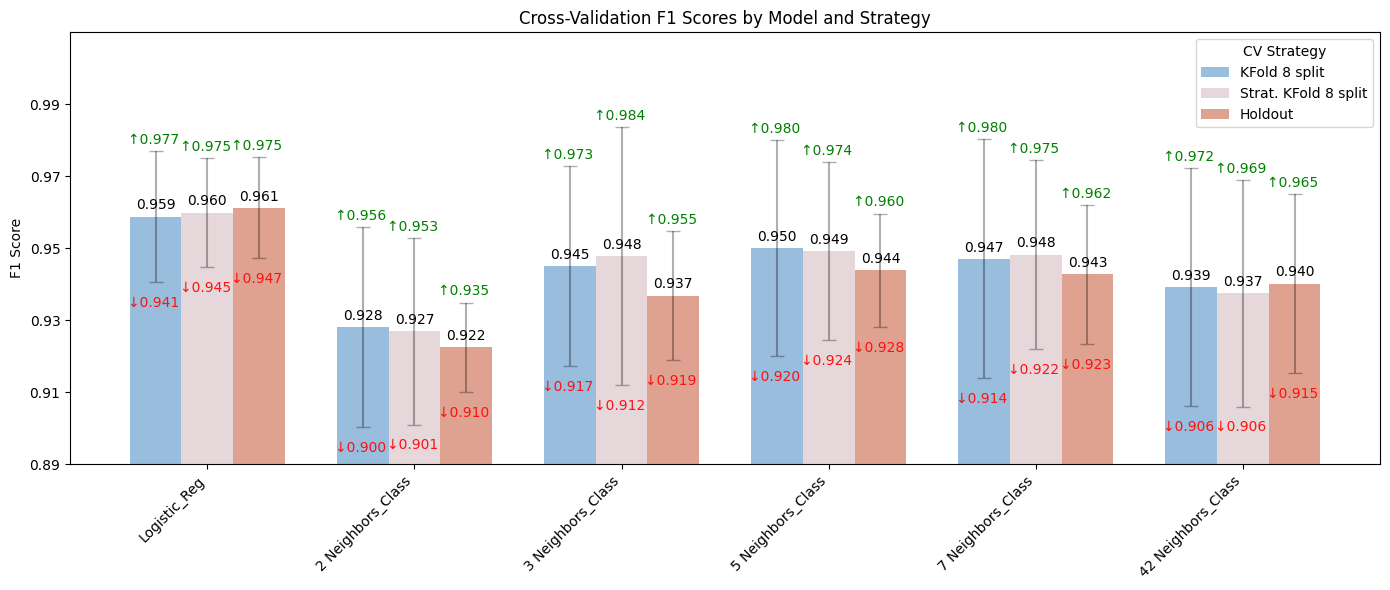

In [188]:
import matplotlib.pyplot as plt
import numpy as np

# --- Prepare data ---
labels = []
f1_means = []
f1_stds = []
strategies = []

for r in results:
    labels.append(r["model"])
    f1_means.append(r["f1_mean"])
    f1_stds.append(r["f1_std"])
    strategies.append(r["cv_strategy"])

# Unique models and strategies
unique_models = list(dict.fromkeys(labels))
unique_strategies = list(dict.fromkeys(strategies))

model_index = {m: i for i, m in enumerate(unique_models)}
strategy_index = {s: j for j, s in enumerate(unique_strategies)}

mean_matrix = np.zeros((len(unique_models), len(unique_strategies)))
std_matrix = np.zeros((len(unique_models), len(unique_strategies)))

for r in results:
    i = model_index[r["model"]]
    j = strategy_index[r["cv_strategy"]]
    mean_matrix[i, j] = r["f1_mean"]
    std_matrix[i, j] = r["f1_std"]


# --- Pastel palette ---
pastel_colors = ["#99BDDD", "#E6D7DB", "#dfa290", "#E6D7DB", "#EFB5CF"]
# You can expand or adjust these hex codes


# --- Plot grouped bar chart ---
x = np.arange(len(unique_models))
width = 0.25

fig, ax = plt.subplots(figsize=(14,6))

for j, strategy in enumerate(unique_strategies):
    # Offset by amount of strategies and a multiplier
    offset = (j - (len(unique_strategies)-1)/2) * width
    # Bars creation with std error adn strategies
    bars = ax.bar(x + offset, mean_matrix[:, j], width,
                yerr=std_matrix[:, j],
                ecolor="#00000050",capsize=5,
                label=strategy, 
                color=pastel_colors[j % len(pastel_colors)])
    # Annotate bars with mean, max, min
    for idx, bar in enumerate(bars):
        mean_val = mean_matrix[idx, j]
        std_val = std_matrix[idx, j]
        max_val = mean_val + std_val
        min_val = mean_val - std_val
        # Mean on bar
        ax.annotate(f"{mean_val:.3f}",
                    xy=(bar.get_x() + bar.get_width()/2, mean_val),
                    xytext=(0,3), textcoords="offset points",
                    ha="center", va="bottom")
        # Max above
        ax.annotate(f"↑{max_val:.3f} ",
                    xy=(bar.get_x() + bar.get_width()/2, max_val),
                    xytext=(0,3), textcoords="offset points",
                    ha="center", va="bottom", color="green")
        # Min below
        ax.annotate(f"↓{min_val:.3f} ",
                    xy=(bar.get_x() + bar.get_width()/2, min_val),
                    xytext=(0,-10), textcoords="offset points",
                    ha="center", va="top", color="#FF1111")

ax.set_ylim(0.89, 1.01)  # zoom in on high F1 range
ax.set_yticks(np.arange(0.89, 1.01, 0.02))
ax.set_ylabel("F1 Score")
ax.set_title("Cross-Validation F1 Scores by Model and Strategy")
ax.set_xticks(x)
ax.set_xticklabels(unique_models, rotation=45, ha="right")
ax.legend(title="CV Strategy")

plt.tight_layout()
plt.show()